In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image
import os

In [2]:
!unzip dataset.zip
!rm dataset.zip
!ls

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/round_wall_clock_01.jpg  
  inflating: dataset/round_wrist_watch_01.jpg  
  inflating: dataset/round_wrist_watch_02.jpg  
  inflating: dataset/round_wrist_watch_03.jpg  
  inflating: dataset/square_wall_clock_01.jpg  
  inflating: dataset/square_wrist_watch_01.jpg  
  inflating: dataset/square_wrist_watch_02.jpg  
  inflating: dataset/square_wrist_watch_03.jpg  
  inflating: dataset/sunglasses_01.jpg  
dataset  sample_data


In [3]:
# Load ResNet50 model, pre-trained on the ImageNet dataset.
# include_top=False means we are using the convolutional base (feature extraction layers)
# and excluding the final classification layers. This is essential for transfer learning.
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# extrats the features of the image
def extract_features(image_path, model):
    try:
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Preprocess the image array according to ResNet50 requirements
        img_array = preprocess_input(img_array)

        # Predict features using the model
        features = model.predict(img_array)
        # Flatten the feature vector to a 1D array
        return features.flatten()
    except Exception as e:
        print(f"Error to process {image_path}: {e}")
        return None

In [5]:
# extrats the features of each image from the dataset
dataset_dir = "/content/dataset"
image_paths = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

dataset_features = {}
for img_path in image_paths:
    features = extract_features(img_path, base_model)
    dataset_features[img_path] = features

# Get the dimension of the feature vectors (e.g., 2048 for ResNet50 with pooling)
# This is done by taking the first feature vector and checking its shape.
feature_dim = list(dataset_features.values())[0].shape[0]

# Initialize with zeros.
feature_matrix = np.zeros((len(dataset_features), feature_dim))

# Fill the feature_matrix and paths_list
paths_list = []
for i, (img_path, features) in enumerate(dataset_features.items()):
    feature_matrix[i, :] = features
    paths_list.append(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


In [6]:
# Extract features from the test image
test_image_path = "/content/square_wrist_watch_test.jpg"
test_features = extract_features(test_image_path, base_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step



Test image:


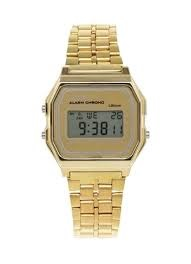


5 most similar images:
Similarity: 0.8073


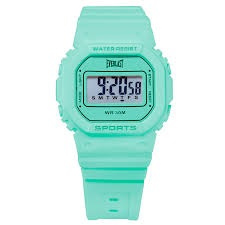

Similarity: 0.5903


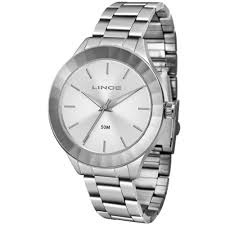

Similarity: 0.5659


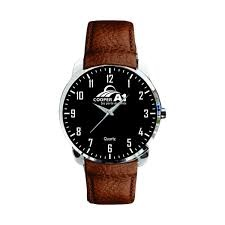

Similarity: 0.5295


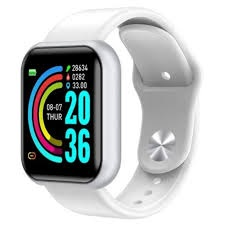

Similarity: 0.4838


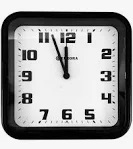

In [9]:
# Calculate the similarity and find the objetcs most similar.
if test_features is not None and feature_matrix.shape[0] > 0:

   # test_features needs to have the same shape of feature_matrix.
    test_features = test_features.reshape(1, -1)

    # Calculate cosine similarity between the test image features and all dataset image features.
    similarities = cosine_similarity(test_features, feature_matrix)[0]

    # Get the indices of the top 5 most similar images.
    most_similar_indices = np.argsort(similarities)[::-1][:5]

    # Display the test image
    print("\nTest image:")
    img_pil = Image.open(test_image_path)
    display(tf.keras.preprocessing.image.array_to_img(np.array(img_pil)))

    # Display the 5 most similar images
    print("\n5 most similar images:")
    for i in most_similar_indices:
        print(f"Similarity: {similarities[i]:.4f}")
        img_pil = Image.open(paths_list[i])
        display(tf.keras.preprocessing.image.array_to_img(np.array(img_pil)))

else:
    print("\nCould not perform similarity comparison. Ensure test image features were extracted and dataset is loaded.")